In [2]:
df = spark.read.parquet('s3://adtech-ml-perf-ads-us-east-1-prod-v1/live_inventory_forecasting/data/DAU_full_v2/all/').toPandas()

In [3]:
df

,ds,vv,sub_vv,__index_level_0__
0,2019-01-01,14514133.0,300291.0,0
1,2019-01-02,15069734.0,293912.0,1
2,2019-01-03,16937687.0,334969.0,2
3,2019-01-04,15608532.0,318765.0,3
4,2019-01-05,16461513.0,325161.0,4
...,...,...,...,...
1516,2023-02-25,26766792.0,12509535.0,0
1517,2023-02-26,28310103.0,13823815.0,0
1518,2023-02-27,25463730.0,11932397.0,0
1519,2023-02-28,25967167.0,11651294.0,0


In [24]:
import pandas as pd
n_sub = pd.read_parquet('n_sub.parquet')
n_sub['ds'] = n_sub.cd.map(str)

In [26]:
df2 = df.merge(n_sub, on='ds')
df2

,ds,vv,sub_vv,__index_level_0__,free,sub_num,cd
0,2019-05-07,47972625.0,1579726.0,126,46392899.0,3276996,2019-05-07
1,2019-05-08,47653991.0,1518503.0,127,46135488.0,3297143,2019-05-08
2,2019-05-09,31593833.0,1112943.0,128,30480890.0,3312469,2019-05-09
3,2019-05-10,48296643.0,1499243.0,129,46797400.0,3337835,2019-05-10
4,2019-05-11,29269399.0,1057325.0,130,28212074.0,3350572,2019-05-11
...,...,...,...,...,...,...,...
1366,2023-02-01,40696639.0,20526892.0,0,20169747.0,48877838,2023-02-01
1367,2023-02-02,35049026.0,15397728.0,0,19651298.0,48798333,2023-02-02
1368,2023-02-03,26346411.0,11873967.0,0,14472444.0,48470236,2023-02-03
1369,2023-02-04,26729924.0,12235515.0,0,14494409.0,48397451,2023-02-04


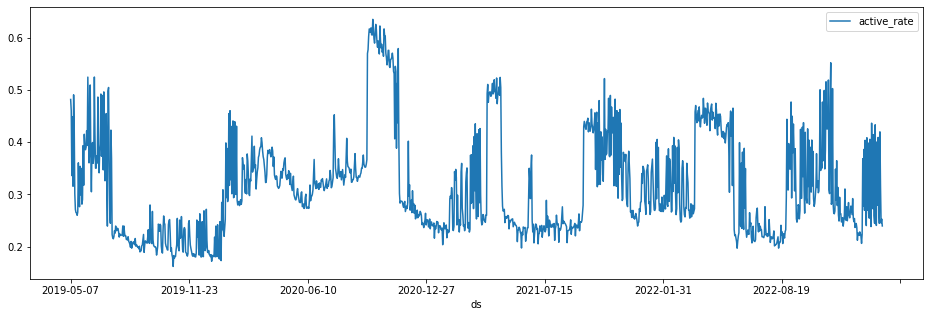

In [27]:
df2['active_rate'] = df2.sub_vv / df2.sub_num
df2.plot(x='ds', y='active_rate', figsize=(16, 5)); # active rate is not stable

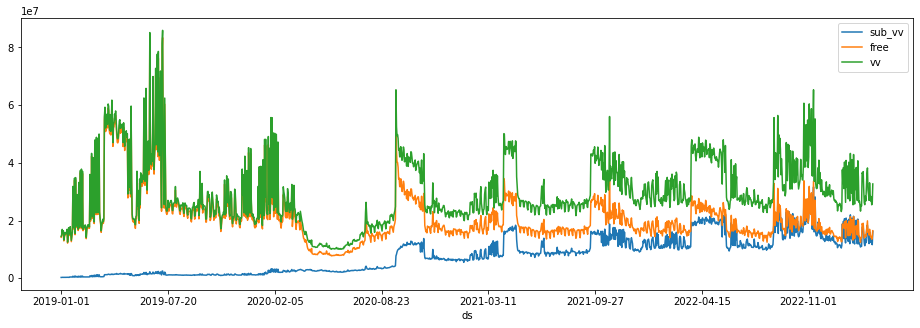

In [10]:
df['free']=df['vv']-df['sub_vv']
df.plot(x='ds', y=['sub_vv', 'free', 'vv'], figsize=(16,5));

In [28]:
from prophet import Prophet
import pandas as pd
holidays = pd.read_csv('holidays_v2.csv')

Importing plotly failed. Interactive plots will not work.


In [40]:
def predict(df):
    m = Prophet(holidays=holidays)
    m.add_country_holidays(country_name='IN')
    model = m.fit(df)
    future = m.make_future_dataframe(periods=365)
    forecast = m.predict(future)
    m.plot(forecast)
    return m

In [ ]:
m = predict(df.rename(columns={'vv': 'y'}))

In [ ]:
m2 = predict(df.rename(columns={'sub_vv': 'y'}))

In [43]:
%store m m2

Stored 'm' (Prophet)
Stored 'm2' (Prophet)


In [44]:
def plot_future(m):
    future = m.make_future_dataframe(periods=365)
    forecast = m.predict(future)
    m.plot(forecast, figsize=(16,5));

/home/hadoop/.local/lib/python3.7/site-packages/prophet/hdays.py:209: Warning: We only support Diwali and Holi holidays from 2010 to 2030
  warnings.warn(warning_msg, Warning)
/home/hadoop/.local/lib/python3.7/site-packages/prophet/hdays.py:209: Warning: We only support Diwali and Holi holidays from 2010 to 2030
  warnings.warn(warning_msg, Warning)


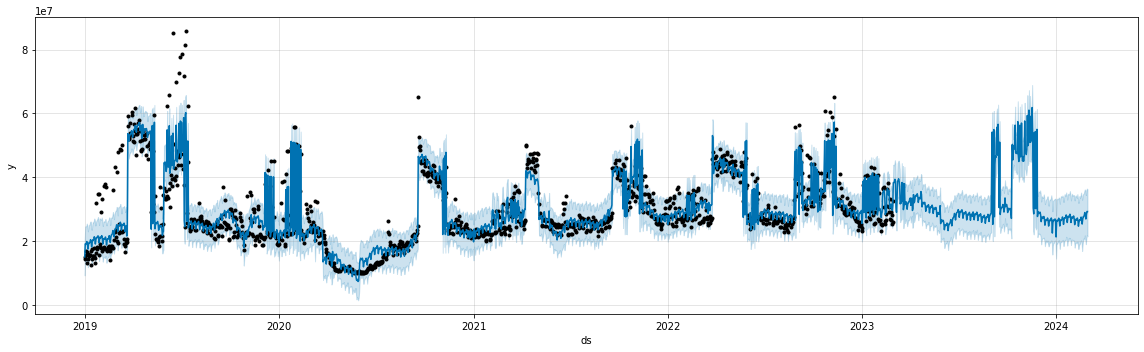

In [45]:
plot_future(m)

In [49]:
future = m.make_future_dataframe(periods=365)
f = m.predict(future)

/home/hadoop/.local/lib/python3.7/site-packages/prophet/hdays.py:209: Warning: We only support Diwali and Holi holidays from 2010 to 2030
  warnings.warn(warning_msg, Warning)
/home/hadoop/.local/lib/python3.7/site-packages/prophet/hdays.py:209: Warning: We only support Diwali and Holi holidays from 2010 to 2030
  warnings.warn(warning_msg, Warning)


In [55]:
f.to_csv('dau_prediction.csv', index=False)

In [56]:
f2.to_csv('subs_dau_prediction.csv', index=False)

In [51]:
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

In [ ]:
t = cross_validation(m, initial='730 days', period='30 days', horizon = '365 days', parallel="processes")
met = performance_metrics(t)
plot_cross_validation_metric(t, metric='mape');

11:12:45 - cmdstanpy - INFO - Chain [1] start processing
11:12:49 - cmdstanpy - INFO - Chain [1] start processing
11:12:51 - cmdstanpy - INFO - Chain [1] start processing
11:12:52 - cmdstanpy - INFO - Chain [1] start processing
11:12:59 - cmdstanpy - INFO - Chain [1] done processing
11:12:59 - cmdstanpy - INFO - Chain [1] done processing
11:13:00 - cmdstanpy - INFO - Chain [1] done processing
11:13:08 - cmdstanpy - INFO - Chain [1] done processing
11:13:18 - cmdstanpy - INFO - Chain [1] start processing
11:13:18 - cmdstanpy - INFO - Chain [1] start processing
11:13:20 - cmdstanpy - INFO - Chain [1] start processing
11:13:20 - cmdstanpy - INFO - Chain [1] done processing
11:13:20 - cmdstanpy - INFO - Chain [1] done processing
11:13:21 - cmdstanpy - INFO - Chain [1] done processing
11:13:22 - cmdstanpy - INFO - Chain [1] start processing
11:13:29 - cmdstanpy - INFO - Chain [1] done processing
11:13:45 - cmdstanpy - INFO - Chain [1] start processing
11:13:46 - cmdstanpy - INFO - Chain [1]

/home/hadoop/.local/lib/python3.7/site-packages/prophet/hdays.py:209: Warning: We only support Diwali and Holi holidays from 2010 to 2030
  warnings.warn(warning_msg, Warning)
/home/hadoop/.local/lib/python3.7/site-packages/prophet/hdays.py:209: Warning: We only support Diwali and Holi holidays from 2010 to 2030
  warnings.warn(warning_msg, Warning)


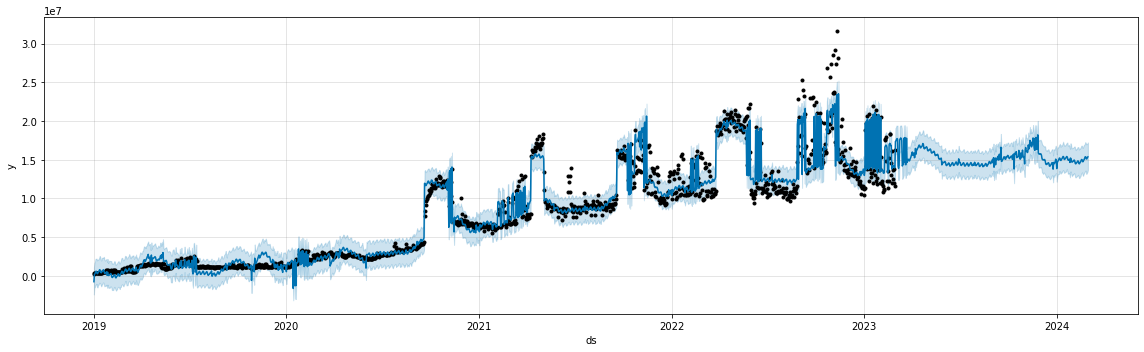

In [46]:
plot_future(m2)

In [50]:
future = m2.make_future_dataframe(periods=365)
f2 = m2.predict(future)

/home/hadoop/.local/lib/python3.7/site-packages/prophet/hdays.py:209: Warning: We only support Diwali and Holi holidays from 2010 to 2030
  warnings.warn(warning_msg, Warning)
/home/hadoop/.local/lib/python3.7/site-packages/prophet/hdays.py:209: Warning: We only support Diwali and Holi holidays from 2010 to 2030
  warnings.warn(warning_msg, Warning)


In [ ]:
%%capture
t2 = cross_validation(m2, initial='730 days', period='30 days', horizon = '365 days', parallel="processes")
met2 = performance_metrics(t2)
plot_cross_validation_metric(t2, metric='mape');